In [4]:
pip install yfinance
























You should consider upgrading via the '/opt/python/envs/default/bin/python -m pip install --upgrade pip' command.

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install yahooquery
















You should consider upgrading via the '/opt/python/envs/default/bin/python -m pip install --upgrade pip' command.

Note: you may need to restart the kernel to use updated packages.


In [6]:
# Raw Package
import numpy as np
import pandas as pd

#Data Source
import yfinance as yf

#Data viz
import plotly.graph_objs as go

from re import search
from yahooquery import Screener

In [7]:
def getRates(ticker_input ,period_input  ,interval_input ):
    print(ticker_input+" "+period_input+" "+interval_input )
    data = yf.download(tickers=ticker_input, period = period_input, interval = interval_input)
    return data["Open"] 

In [8]:
def getPercChange(d):
    x=round(d.head(1),6).values
    y=round(d.tail(1),6).values
    perc_chg= np.round( (  (y-x) / abs(x)  ) *100  , 4)
    return perc_chg

In [9]:
def mail2me(pair_text,message_text):
    from email.message import EmailMessage
    import smtplib

    sender = "ozukun83@gmail.com"
    recipient = "ozukun83@gmail.com"
    message = "Crypto Info all"

    password = input("Type your password and press enter: ")
    
    email = EmailMessage()
    email["From"] = sender
    email["To"] = recipient
    email["Subject"] = "Crypto Rates Python!"+"  "+pair_text
    email.set_content(message_text)

    smtp = smtplib.SMTP_SSL("smtp.gmail.com")
    smtp.login(sender, password)
    smtp.sendmail(sender, recipient, email.as_string())
    smtp.quit()
    print("Mail succeed !!")

In [10]:
# get all crypto pairs with USD
def getCryptoPairs():
    s = Screener()
    tickers=[]
    data = s.get_screeners('all_cryptocurrencies_us', count=10)

    # data is in the quotes key
    dicts = data['all_cryptocurrencies_us']['quotes']
    symbols = [d['symbol'] for d in dicts]
    symbols[0]

    for s in symbols:
        if  search("USD", s) and not search("USDT", s) and not search("USDC", s): #\
        #and ( search("ETH",s) or search("DOGE",s) ):
            #print(s+"\n")
            tickers.append(s)
             
    return tickers
        

for cp in getCryptoPairs():
    print(cp)

BTC-USD

ETH-USD

BNB-USD

XRP-USD

BUSD-USD

DOGE-USD

ADA-USD

MATIC-USD


In [11]:
Crypto_Pairs=["BTC-USD","ETH-USD","ALGO-USD","SOL-USD","LUNC-USD","ROSE-USD","SHIB-USD","FTT-USD","ADA-USD"]

message_input=""
final_message=""
for cp in Crypto_Pairs:
    print(cp)
    df_tmp=getRates(cp,  '3mo',  '1h')
    message_input=cp+"   First: "+str( round( df_tmp.head(1)[0] ,6 ) )+"  "+"Last: "+str( round(df_tmp.tail(1)[0] ,6)  )
    df3mo=getRates(cp,  '3mo',  '1h')
    message_input0=cp+"  '3mo',  '1h' CHANGE % " +str( getPercChange(df3mo)[0])
    
    df1mo=getRates(cp,  '1mo',  '1h')
    message_input1=cp+"  '1mo',  '1h' CHANGE % " +str( getPercChange(df1mo)[0])
    
    dfwk=getRates(cp,'1wk',  '1h')
    message_input2=cp+"  '1wk',  '1h' CHANGE % " +str( getPercChange(dfwk)[0])
    
    message_input=message_input+"\n"+message_input0+"\n"+message_input1+"\n"+message_input2+"\n"+"\n"
    final_message=final_message+message_input
    print(final_message)
    
    
mail2me("All Crypto Pairs",final_message) 

BTC-USD

BTC-USD 3mo 1h

[*********************100%***********************]  1 of 1 completed

BTC-USD 3mo 1h

[*********************100%***********************]  1 of 1 completed

BTC-USD 1mo 1h

[*********************100%***********************]  1 of 1 completed

BTC-USD 1wk 1h

[*********************100%***********************]  1 of 1 completed

BTC-USD   First: 19573.224609  Last: 16603.673828

BTC-USD  '3mo',  '1h' CHANGE % -15.1715

BTC-USD  '1mo',  '1h' CHANGE % 0.962

BTC-USD  '1wk',  '1h' CHANGE % -1.1508





ETH-USD

ETH-USD 3mo 1h

[*********************100%***********************]  1 of 1 completed

ETH-USD 3mo 1h

[*********************100%***********************]  1 of 1 completed

ETH-USD 1mo 1h

[*********************100%***********************]  1 of 1 completed

ETH-USD 1wk 1h

[*********************100%***********************]  1 of 1 completed

BTC-USD   First: 19573.224609  Last: 16603.673828

BTC-USD  '3mo',  '1h' CHANGE % -15.1715

BTC-USD  '1mo',  '1h' CHANGE

In [16]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

def getLine(df_input):
    x = df_input.index
    y = df_input.values
    fig = go.Figure(data=go.Scatter(x = x, y = y))
    fig.show()

ETH-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed


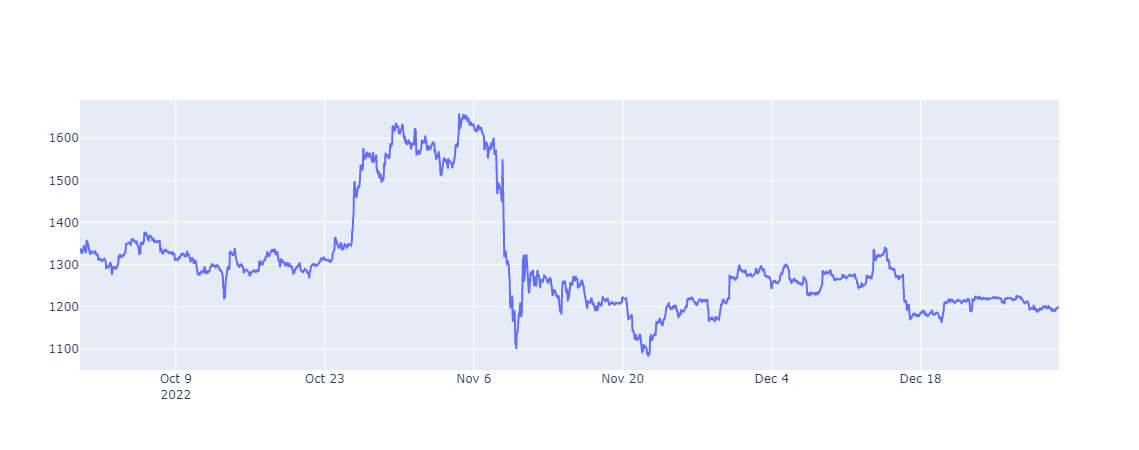

ALGO-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed


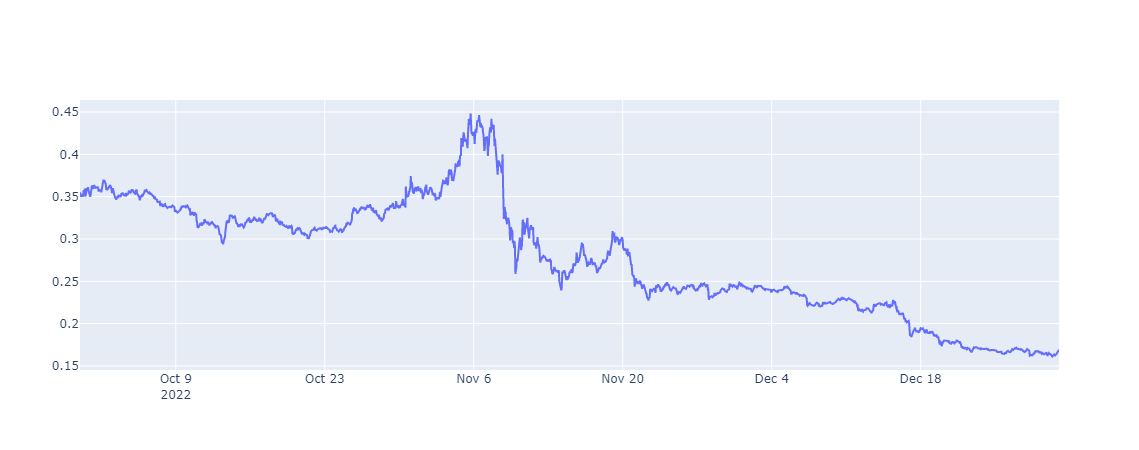

In [17]:
( getLine(getRates('ETH-USD',  '3mo',  '1h')) )
( getLine(getRates('ALGO-USD',  '3mo',  '1h')) )